## Acknowledgement:

*  "Deep Learning for Liver Segmentation" implementation by Soriba Diaby at [the following link](https://github.com/soribadiaby/Deep-Learning-liver-segmentation);


*   Original Paper " U-Net: Convolutional Networks for Biomedical Image Segmentation" by Olaf Ronneberger, Philipp Fischer, and Thomas Brox at the [following link](https://arxiv.org/pdf/1505.04597.pdf);


## Goal of the Project:

Biomedical image processing often has been experiencing a problem of insufficient number of annotated input images available.  

Additionally, medical imaging requires localisation (e.g. classification of every pixel) or medical image segmentation.

Goal of this project is to reproduce medical images segmentation experiment, created by  Soriba D., and to learn how dataset with few samples could be used for medical images segmentation.

## Set-Up


In [ ]:
#Project Folder:
%cd /content/drive/MyDrive/Medical_Images_Segmentation

/content/drive/MyDrive/Medical_Images_Segmentation


In [ ]:
import os
import datetime
import numpy as np
import pandas as pd 
import nibabel
import random
import sys

import keras
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, concatenate, Conv2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.merge import add, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

from keras import backend as K
from keras.callbacks import History

import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split

from __future__ import print_function

import skimage
from skimage import img_as_ubyte, img_as_float32, img_as_uint
import skimage.transform 
from skimage.transform import resize
import skimage.io 
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io
from scipy import ndimage as ndi
from skimage.morphology import label, ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from skimage.io import imread
import scipy.misc

import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from glob import glob

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)


Python       : 3.7.10 (default, Feb 20 2021, 21:17:23) 
Numpy        : 1.19.5
Skimage      : 0.16.2
Scikit-learn : 0.22.2.post1
Keras        : 2.4.3
Tensorflow   : 2.4.1


In [ ]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

##Preparing Data

In [ ]:
BASE_IMG_PATH=os.path.join('/content/drive/MyDrive/Medical_Images_Segmentation','raw')

In [ ]:
image_rows = int(512/2)
image_cols = int(512/2) 


def create_train_data():
    print('-'*30)
    print('Creating training data...')
    print('-'*30)
    train_data_path = os.path.join(BASE_IMG_PATH,'train','*')
    images = sorted(glob(train_data_path))


    #training images
    imgs_train = [] 
    #training masks (corresponding to the liver)
    masks_train = [] 
   
    #file names corresponding to training masks
    training_masks = images[::2]
    #file names corresponding to training images
    training_images = images[1::2] 

     
    for liver, orig in zip(training_masks, training_images):
        #we load 3D training mask (shape=(512,512,129))
        training_mask = nibabel.load(os.path.join(train_data_path, liver))
        #we load 3D training image
        training_image = nibabel.load(os.path.join(train_data_path, orig)) 
        
        for k in range(training_mask.shape[2]-1):
            #axial cuts are made along the z axis with undersampling
            mask_2d = np.array(training_mask.get_fdata()[::2, ::2, k]) 
            image_2d = np.array(training_image.get_fdata()[::2, ::2, k])
            #we only recover the 2D sections containing the liver
            #if mask_2d contains only 0, it means that there is no liver
            if len(np.unique(mask_2d)) != 1:
                masks_train.append(mask_2d)
                imgs_train.append(image_2d)
    
    imgs = np.ndarray(
            (len(imgs_train), image_rows, image_cols), dtype='uint8'
            )
    

    imgs_mask = np.ndarray(
            (len(masks_train), image_rows, image_cols), dtype='uint8'
            )

    for index, img in enumerate(imgs_train):
        imgs[index, :, :] = img
        
    for index, img in enumerate(masks_train):
        imgs_mask[index, :, :] = img

    np.save('imgs_train.npy', imgs)
    np.save('masks_train.npy', imgs_mask)
    print('Saving to .npy files done.')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    masks_train = np.load('masks_train.npy')
    return imgs_train, masks_train

In [ ]:
create_train_data()

------------------------------
Creating training data...
------------------------------
Saving to .npy files done.


In [ ]:
def create_test_data():
    print('-'*30)
    print('Creating test data...')
    print('-'*30)
    test_data_path = os.path.join(BASE_IMG_PATH, 'test')
    images = os.listdir(test_data_path)   
    imgs_test = []
    masks_test = []
    
    for image_name in images:
        #print(image_name)
        img = nibabel.load(os.path.join(test_data_path, image_name))
        #print(img.shape)
        
        for k in range(img.shape[2]):  
            img_2d = np.array(img.get_fdata()[::2, ::2, k])
            
            if 'liver' in image_name:
                masks_test.append(img_2d)
            
            elif 'orig' in image_name:
                imgs_test.append(img_2d)
                      
    imgst = np.ndarray(
            (len(imgs_test), image_rows, image_cols), dtype=np.uint8
            )
    imgs_maskt = np.ndarray(
            (len(masks_test), image_rows, image_cols), dtype=np.uint8
            )
    for index, img in enumerate(imgs_test):
        imgst[index, :, :] = img
        
    for index, img in enumerate(masks_test):
        imgs_maskt[index, :, :] = img

    np.save('imgs_test.npy', imgst)
    np.save('masks_test.npy', imgs_maskt)
    print('Saving to .npy files done.')

def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    masks_test = np.load('masks_test.npy')
    return imgs_test, masks_test

In [ ]:
create_test_data()

------------------------------
Creating test data...
------------------------------
Saving to .npy files done.


## Defining the Model

In [ ]:
img_rows = int(512/2)
img_cols = int(512/2)
smooth = 1.

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

## Training the Model

In [ ]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    #Normalization of the train set

    imgs_mask_train = imgs_mask_train.astype('float32')
    

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(imgs_train, imgs_mask_train, batch_size=10, epochs=25, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_maskt = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(-1,1))
        b=(imgs_mask_test[k][:,:,0]).astype('uint8')
        io.imsave(os.path.join(pred_dir, str(k) + '_pred.png'),mark_boundaries(a,b))
        
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
import imageio.core.util

def ignore_warnings(*args, **kwargs):
    pass

imageio.core.util._precision_warn = ignore_warnings

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/25
116/116 [==============================] - 63s 228ms/step - loss: -0.3809 - dice_coef: 0.3810 - val_loss: -0.6823 - val_dice_coef: 0.6807
Epoch 2/25
116/116 [==============================] - 21s 182ms/step - loss: -0.8259 - dice_coef: 0.8259 - val_loss: -0.6885 - val_dice_coef: 0.6880
Epoch 3/25
116/116 [==============================] - 22s 188ms/step - loss: -0.8682 - dice_coef: 0.8682 - val_loss: -0.7258 - val_dice_coef: 0.7262
Epoch 4/25
116/116 [==============================] - 23s 195ms/step - loss: -0.8960 - dice_coef: 0.8960 - val_loss: -0.8182 - val_dice_coef: 0.8176
Epoch 5/25
116/116 [==============================] - 23s 195ms/step - loss: -0.8968 - dice_coef: 0.8968 - val_loss: -0.7593 - va

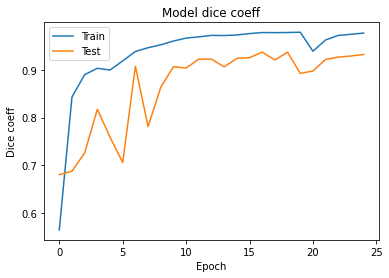

In [ ]:
train_and_predict()

##Plotting Few Predictions

(-0.5, 255.5, 255.5, -0.5)

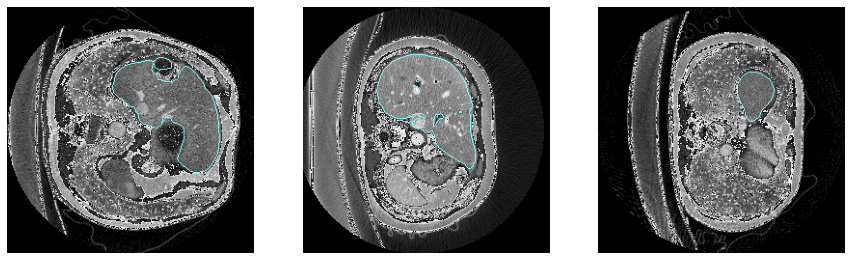

In [ ]:
# display few predictions:
fig = plt.figure(figsize=(15, 7)) 
  
# setting values to rows and column variables 
rows = 1
columns = 3
  
# reading images 
Image1 = cv2.imread('./test_preds/503_pred.png') 
Image2 = cv2.imread('./test_preds/587_pred.png') 
Image3 = cv2.imread('./test_preds/769_pred.png') 
 
  
# 1st subplot
fig.add_subplot(rows, columns, 1) 
plt.imshow(Image1) 
plt.axis('off') 
#plt.title("First") 
  
# 2nd subplot
fig.add_subplot(rows, columns, 2) 
plt.imshow(Image2) 
plt.axis('off') 
#plt.title("Second") 

# 3d subplot
fig.add_subplot(rows, columns, 3)  
plt.imshow(Image3) 
plt.axis('off') 
#plt.title("Third") 